In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import mannwhitneyu
from tools import *

phasepro_all_pth = 'data_source/data_collection/PhaSePro_data_all.tsv'

column_names = [str(x) for x in range(1,37)]
column_names[0] = 'gene_name'
column_names[2] = 'uniprot_id'
column_names[3] = 'species'
column_names[4] = 'seq'
column_names[9] = 'ps_regions'
phasepro_all_df = pd.read_csv(phasepro_all_pth,sep='\t',
                              names=column_names,
                              skiprows=7)
df_all = phasepro_all_df.copy()
region_collections = []
seq2regionbool = {} ### {'seq1':[0,0,1,1,1,0,0,...]}
seq2regionlst = {} ### {'seq1':[[10,20],[45,70]]}
uids_ = phasepro_all_df['uniprot_id'].values
'''
Process PhaSePro data
'''
for i,(region_str,seq) in enumerate(zip(phasepro_all_df['ps_regions'].values,
                          phasepro_all_df['seq'].values)):
    try:
        count = 0
        domain_len_collection = []
        region_bool_lst = np.zeros(len(seq))
        region_lst = []
        for domain in region_str.split('; '):
            if len(domain) == 0:
                continue
            start,end = domain.split('-')[0],domain.split('-')[1]
            start,end = int(start),int(end)
            count += end-start
            domain_len_collection.append(count)
            region_bool_lst[int(start):int(end)] = 1
            if start > len(seq):### some values miss match in the phasepro db
                print(uids_[i],region_str)
                continue 
            if end > len(seq):## some values miss match in the phasepro db
                print(uids_[i],region_str)
                end = len(seq)
            region_lst.append([start,end])    
        region_collections.append(
            (len(seq),domain_len_collection,count,region_str))
        #### get a region bool lst like[0,0,1,1,1,1,0...]
        seq2regionbool[seq] = list(region_bool_lst)
        # print(len(seq),len(region_bool_lst))
        seq2regionlst[seq] = region_lst
    except:
        region_collections.append(
            (np.inf,[],np.inf,''))
seq_len_lst = []    
ps_domain_area_length = []
ps_domain_len_collection = []         
for row in region_collections:
    ps_domain_area_length.append(row[2])
    ps_domain_len_collection += row[1]
    seq_len_lst.append(row[0])


O13828 1-289; 553-771
O94752 1-86; 231-551
Q09737 1-750; 880-1076
Q09737 1-750; 880-1076


/tmp/ipykernel_25915/91963673.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ps_domain_len_collection, alpha=0.3,linewidth=2,


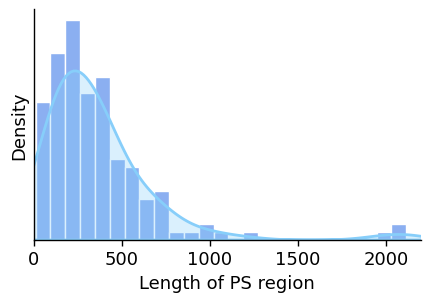

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(ps_domain_len_collection, edgecolor='white',stat='density',
         bins=25, alpha=0.75, color='cornflowerblue',
         zorder=0)  
sns.kdeplot(ps_domain_len_collection, alpha=0.3,linewidth=2,
            shade=True, color='lightskyblue',bw_adjust=1, label='Benign',
            zorder=2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,
               labelsize=13,)

plt.xlim(0,2200)
plt.xlabel('Length of PS region',fontsize=13,)  
plt.ylabel('Density',fontsize=13,) 
plt.yticks([])
plt.title('')  
plt.show()


In [3]:
ps_domain_info_df = pd.DataFrame()

ps_domain_info_df['uniprot_id'] = phasepro_all_df['uniprot_id'].values
ps_domain_info_df['seq'] = phasepro_all_df['seq'].values
ps_domain_info_df['gene_name'] = phasepro_all_df['gene_name'].values 
ps_domain_info_df['seq_len'] = np.array(seq_len_lst)
ps_domain_info_df['area'] = phasepro_all_df['ps_regions'].values
ps_domain_info_df['ps_region_size'] = np.array(ps_domain_area_length)
ps_domain_info_df.sort_values(by='ps_region_size',inplace=True,ignore_index=True)
ps_domain_info_df.dropna(inplace=True,)
ps_domain_info_df.reset_index(inplace=True,drop=True)


In [4]:
'''
Predict using PSTP
'''

from tools import *
from tools_nn_related import *
from scipy.stats import pearsonr,spearmanr 
full_sequences = ps_domain_info_df['seq'].values
sequences = [
    check_seq_tool(seq) for seq in full_sequences]
# seq_matrix_lst = seq2matrix_lst(sequences)
# saps_seqwide_scores_lst,pdps_seqwide_scores_lst,mix_seqwide_scores_lst = [],[],[]
# saps_py_lst,pdps_py_lst,mix_py_lst = [],[],[]
# bestscore_seqwide_scores_lst = []
# best_type_lst = []
# print('predicting')
# for matrix_ in seq_matrix_lst:
#     win_score1,p1 = predict_by_saps_models(matrix_,True)
#     saps_py_lst.append(p1)
#     saps_seqwide_scores_lst.append(win_score1)
#     win_score2,p2 = predict_by_pdps_models(matrix_,True)
#     pdps_py_lst.append(p2)
#     pdps_seqwide_scores_lst.append(win_score2)
#     win_score3,p3 = predict_by_mix_models(matrix_,True)
#     mix_py_lst.append(p3)
#     mix_seqwide_scores_lst.append(win_score3)
#     if p1 == max(p1,p2,p3):
#         bestscore_seqwide_scores_lst.append(win_score1)
#         best_type_lst.append('SaPS')
#     elif p2 == max(p1,p2,p3):
#         bestscore_seqwide_scores_lst.append(win_score2)
#         best_type_lst.append('PdPS')
#     else:
#         bestscore_seqwide_scores_lst.append(win_score3)
#         best_type_lst.append('Mix')
# print('prediction completed')
# np.save('data_processed/PhaSePro_analyze/saps_seqwide_scores_lst.npy',saps_seqwide_scores_lst,)
# np.save('data_processed/PhaSePro_analyze/pdps_seqwide_scores_lst.npy',pdps_seqwide_scores_lst,)
# np.save('data_processed/PhaSePro_analyze/mix_seqwide_scores_lst.npy',mix_seqwide_scores_lst,)
# np.save('data_processed/PhaSePro_analyze/best_seqwide_scores_lst.npy',
#         bestscore_seqwide_scores_lst,)
# np.save('data_processed/PhaSePro_analyze/best_type_lst.npy',
#         best_type_lst,)
saps_seqwide_scores_lst = np.load(
    'data_processed/PhaSePro_analyze/saps_seqwide_scores_lst.npy',
    allow_pickle=True,
)
pdps_seqwide_scores_lst = np.load(
    'data_processed/PhaSePro_analyze/pdps_seqwide_scores_lst.npy',
     allow_pickle=True,
)
mix_seqwide_scores_lst = np.load(
    'data_processed/PhaSePro_analyze/mix_seqwide_scores_lst.npy',
     allow_pickle=True,
)
bestscore_seqwide_scores_lst = np.load(
    'data_processed/PhaSePro_analyze/best_seqwide_scores_lst.npy',
     allow_pickle=True,
)
best_type_lst = np.load(
    'data_processed/PhaSePro_analyze/best_type_lst.npy',
     allow_pickle=True,
)


loading or downloading model


In [5]:
'''  
process phasepro predicted by fuzdrop webserver
'''
# import os
# import pandas as pd 
# fuzdrop_results_uid2df = {}
# fuzdrop_result_pth = 'data_processed/PhaSePro_analyze/fuzdrop_web_results'
# fuzdrop_all = os.listdir(fuzdrop_result_pth)
# for f in fuzdrop_all:
#     uid = f.split('.')[0][8:]
#     fuzdrop_results_uid2df[uid] = pd.read_csv(
#         f'{fuzdrop_result_pth}/{f}',sep='\t')
# print(fuzdrop_results_uid2df.keys())

# print(ps_domain_info_df['uniprot_id'].values)
# fuzdrop_pDP_all = []
# fuzdrop_Sbind_all = []
# for uid in ps_domain_info_df['uniprot_id'].values:
#     if uid not in fuzdrop_results_uid2df.keys():
#         print(uid)
#     pDP = fuzdrop_results_uid2df[uid]['pDP'].values
#     Sbind = fuzdrop_results_uid2df[uid]['Sbind'].values
#     fuzdrop_pDP_all.append(list(pDP))
#     fuzdrop_Sbind_all.append(list(Sbind))
# print(fuzdrop_pDP_all)
# print(fuzdrop_Sbind_all)
# np.save('data_processed/PhaSePro_analyze/phasepro_fuzpdp.npy',
#         fuzdrop_pDP_all)
# np.save('data_processed/PhaSePro_analyze/phasepro_fuzsbind.npy',
#         fuzdrop_Sbind_all)
    


'  \nprocess phasepro predicted by fuzdrop webserver\n'

In [6]:
def predict_key_regions_bool(psphunter_score_lst):
    len_seq = len(psphunter_score_lst) 
    if len_seq > 2000:
        region_size = int(len_seq*0.01)
    elif len_seq <=2000 and len_seq > 1000:
        region_size = int(len_seq*0.02)
    elif len_seq <=1000 and len_seq > 500:
        region_size = int(len_seq*0.04)
    elif len_seq <=500:
        region_size = int(len_seq*0.05)   
    scores_sorted = np.sort(psphunter_score_lst)
    score_thresh = scores_sorted[:region_size][-1]
    key_regions_bool = np.where(np.array(psphunter_score_lst)<score_thresh,1,0)
    return key_regions_bool
def minmax(lst):
    lst = np.array(lst)
    lst = (lst-np.min(lst))/(np.max(lst)-np.min(lst))
    return list(lst)
sequences = [
    check_seq_tool(seq) for seq in full_sequences]

full_inps_bool_lst = []
full_slide_nn_mix_pos_score = []
full_slide_nn_saps_pos_score = []
full_slide_nn_pdps_pos_score = []
full_slide_nn_best_pos_score = []
full_slide_nn_max_pos_score = []
slide_nn_mix_pear_lst = []
iupred_all = np.load('data_processed/PhaSePro_analyze/phasepro_iupred.npy',
                     allow_pickle=True)
pscore_all = np.load('data_processed/PhaSePro_analyze/phasepro_pscore.npy',
                     allow_pickle=True)
cat_all = np.load('data_processed/PhaSePro_analyze/phasepro_catgra.npy',
                  allow_pickle=True)
psphunter_all = np.load('data_processed/PhaSePro_analyze/phasepro_psphunter.npy',
                  allow_pickle=True)
fuzpdp_all = np.load('data_processed/PhaSePro_analyze/phasepro_fuzpdp.npy',
                  allow_pickle=True)
fuzsbind_all = np.load('data_processed/PhaSePro_analyze/phasepro_fuzsbind.npy',
                  allow_pickle=True)
parse_all = np.load('data_processed/PhaSePro_analyze/phasepro_parse.npy',allow_pickle=True)
plaac_all = np.load('data_processed/PhaSePro_analyze/phasepro_plaac.npy',allow_pickle=True)

''' 
compute overall pearson
'''
full_iupred_all = []
full_catgra_all = []
full_pscore_all = []
full_fuzpdp_all = []
full_fuzsbd_all = []
full_psphunter_all = []
full_parse_all = []
full_plaac_all = []
regionbool_lst = [] 

'''  
list for computing num of mapped regions 
and aa num of mapped regions/total regions/predicted regions
etc.
'''
regions_count = 0
mapped_regions = 0
scanned_regions = 0

fuz_mapped_regions = 0
fuz_scanned_regions = 0
regions_aa_count = 0 
mapped_regions_aa_count = 0
scanned_regions_aa_count = 0
psphunter_mapped_regions_aa_count = 0
psphunter_regions_aa_count = 0
fuzdrop_mapped_regions_aa_count = 0
fuzdrop_regions_aa_count = 0

regions_aa_count_weighted = 0 
mapped_regions_aa_count_weighted = 0
scanned_regions_aa_count_weighted = 0
psphunter_mapped_regions_aa_count_weighted = 0
psphunter_regions_aa_count_weighted = 0
fuzdrop_mapped_regions_aa_count_weighted = 0
fuzdrop_regions_aa_count_weighted = 0

''' 
list to compute seq wide pearson
'''
best_slidenn_seq_pearson = []
mix_slidenn_seq_pearson = []
saps_slidenn_seq_pearson = []
pdps_slidenn_seq_pearson = []
max_slidenn_seq_pearson = []
pscore_seq_pearson = []
iupred_seq_pearson = []
catgra_seq_pearson = []
fuzdrop_seq_pearson = []
hunter_seq_pearson = [] 
parse_seq_pearson = []
plaac_seq_pearson = []

best_slidenn_seq_spear = []
mix_slidenn_seq_spear = []
saps_slidenn_seq_spear = []
pdps_slidenn_seq_spear = []
max_slidenn_seq_spear = []
pscore_seq_spear = []
iupred_seq_spear = []
catgra_seq_spear = []
fuzdrop_seq_spear = []
hunter_seq_spear = [] 
parse_seq_spear = []
plaac_seq_spear = []


def get_spear_pearson(lst1,lst2):
    spear,_ = spearmanr(lst1,lst2)
    pear,_ = pearsonr(lst1,lst2)
    return spear,pear
for i,s in tqdm(enumerate(sequences)):
    areas = ps_domain_info_df['area'].values[i]
    regionbool = seq2regionbool[s]
    regionlst = seq2regionlst[s]
    regionbool_lst.append(regionbool)
    full_inps_bool_lst += regionbool
    ''' 
    extend list for overall pearson 
    '''
    full_iupred_all += list(iupred_all[i])
    full_pscore_all += list(pscore_all[i])
    full_catgra_all += list(cat_all[i])
    full_psphunter_all += list(minmax(np.array(psphunter_all[i]))) # normalization
    full_fuzpdp_all += list(fuzpdp_all[i])
    full_fuzsbd_all += list(fuzsbind_all[i])
    full_parse_all += list(parse_all[i])
    full_plaac_all += list(minmax(np.array(plaac_all[i])))
    slide_nn_mix_score_lst = mix_seqwide_scores_lst[i]
    slide_nn_saps_score_lst = saps_seqwide_scores_lst[i]
    slide_nn_pdps_score_lst = pdps_seqwide_scores_lst[i]
    slide_nn_best_score_lst = bestscore_seqwide_scores_lst[i]
    slide_nn_max_score_lst = np.max(
        np.array([slide_nn_mix_score_lst,slide_nn_saps_score_lst,
         slide_nn_pdps_score_lst]),axis=0)
    full_slide_nn_mix_pos_score += list(slide_nn_mix_score_lst)
    full_slide_nn_saps_pos_score += list(slide_nn_saps_score_lst)
    full_slide_nn_pdps_pos_score += list(slide_nn_pdps_score_lst)
    full_slide_nn_best_pos_score += list(slide_nn_best_score_lst)
    full_slide_nn_max_pos_score += list(slide_nn_max_score_lst)
    '''  
     ### get slide nn ps_regions 
    '''
    win_mark1,_ = compute_window(slide_nn_mix_score_lst,0.5,5,-1)
    win_mark2,_ = compute_window(slide_nn_saps_score_lst,0.5,5,-1)
    win_mark3,_ = compute_window(slide_nn_pdps_score_lst,0.5,5,-1)
    win_mark_merge = np.array(win_mark1)+np.array(win_mark2)+\
        np.array(win_mark3)
    scanned_region_bool,scanned_region_merged\
          = compute_window(win_mark_merge,0.9,20,-1)
    mapped_region_bool = np.min(np.array([
        scanned_region_bool,
        regionbool]
    ),axis=0) 
    regions_aa_count += np.sum(regionbool)
    mapped_regions_aa_count += np.sum(mapped_region_bool)
    scanned_regions_aa_count += np.sum(scanned_region_bool)
    scanned_regions += len(scanned_region_merged)
    regions_aa_count_weighted += 1
    mapped_regions_aa_count_weighted += np.sum(mapped_region_bool)/np.sum(regionbool)
    scanned_regions_aa_count_weighted += np.sum(scanned_region_bool)/np.sum(regionbool)
    
    ''' 
    AA wide comparison of PSPhunter domains
    '''
    ### stats of psphunter on mapping ps region
    psphunter_region_bool = predict_key_regions_bool(
        psphunter_all[i]
    )
    mapped_psphunter_region_bool = np.min(np.array(
        [psphunter_region_bool,
        regionbool]
    ),axis=0)
    psphunter_mapped_regions_aa_count += np.sum(mapped_psphunter_region_bool)
    psphunter_regions_aa_count += np.sum(psphunter_region_bool)
    psphunter_mapped_regions_aa_count_weighted += \
        np.sum(mapped_psphunter_region_bool)/np.sum(regionbool)
    psphunter_regions_aa_count_weighted += \
        np.sum(psphunter_region_bool)/np.sum(regionbool)
    
    ''' 
    AA wide comparison of FuzDrop domains
    '''
    ### stats of fuzdrop on mapping ps region
    fuz_region_bool = np.where(
        np.array(fuzpdp_all[i])>0.599,1,0)
    _,fuz_regions = compute_window(fuzpdp_all[i],0.599,30,-1)
    mapped_fuzdrop_region_bool = np.min(np.array(
        [fuz_region_bool,
        regionbool]
    ),axis=0)
    fuz_scanned_regions += len(fuz_regions)
    fuzdrop_mapped_regions_aa_count += np.sum(mapped_fuzdrop_region_bool)
    fuzdrop_regions_aa_count += np.sum(fuz_region_bool)
    fuzdrop_mapped_regions_aa_count_weighted += \
        np.sum(mapped_fuzdrop_region_bool)/np.sum(regionbool)
    fuzdrop_regions_aa_count_weighted += \
        np.sum(fuz_region_bool)/np.sum(regionbool)
    ''' 
    find PS segments that are overlapped
    predicted/ overlap/ actual
    '''
    for reg in regionlst:
        regions_count += 1
        for scanned_region in scanned_region_merged:
            if (reg[0] - scanned_region[1])*\
                (reg[1] - scanned_region[0])<0:
                    mapped_regions += 1
                    break
    ''' 
    find PS segments that are overlapped (FuzDrop)
    predicted/ overlap/ actual
    '''
    for reg in regionlst:
        for fuz_region in fuz_regions:
            if (reg[0] - fuz_region[1])*\
                (reg[1] - fuz_region[0])<0:
                    fuz_mapped_regions += 1
                    break
    if len(Counter(regionbool).keys()) == 2 and \
        Counter(regionbool)[0] >= 20:
    # Counter(regionbool)[0]<len(regionbool)*0.995:
    
        ### for slidenn 
        
        ### compute pearson for each sequence 
        spr_,pr_ = get_spear_pearson(regionbool,slide_nn_best_score_lst)   
        best_slidenn_seq_spear.append(spr_)
        best_slidenn_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,slide_nn_mix_score_lst)   
        mix_slidenn_seq_spear.append(spr_)
        mix_slidenn_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,slide_nn_saps_score_lst)   
        saps_slidenn_seq_spear.append(spr_)
        saps_slidenn_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,slide_nn_pdps_score_lst)   
        pdps_slidenn_seq_spear.append(spr_)
        pdps_slidenn_seq_pearson.append(pr_)
        
        spr_,pr_ = get_spear_pearson(regionbool,pscore_all[i])   
        pscore_seq_spear.append(spr_)
        pscore_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,cat_all[i])   
        catgra_seq_spear.append(spr_)
        catgra_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,psphunter_all[i])   
        hunter_seq_spear.append(spr_)
        hunter_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,fuzpdp_all[i])   
        fuzdrop_seq_spear.append(spr_)
        fuzdrop_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,iupred_all[i])   
        iupred_seq_spear.append(spr_)
        iupred_seq_pearson.append(pr_)
        spr_,pr_ = get_spear_pearson(regionbool,parse_all[i])   
        parse_seq_pearson.append(pr_)
        parse_seq_spear.append(spr_)
        spr_,pr_ = get_spear_pearson(regionbool,plaac_all[i])   
        plaac_seq_pearson.append(pr_)
        plaac_seq_spear.append(spr_)

''' 
analyze pearson
'''
print('####################')
print('overall pearson (stacking aa together)')
print('pstp-scan',spearmanr(full_slide_nn_best_pos_score,full_inps_bool_lst))
print('iupred',spearmanr(full_iupred_all,full_inps_bool_lst))
print('pscore',spearmanr(full_pscore_all,full_inps_bool_lst))
print('catgranule',spearmanr(full_catgra_all,full_inps_bool_lst))
print('psphunter',spearmanr(full_psphunter_all,full_inps_bool_lst))
print('fuzdrop_pdb',spearmanr(full_fuzpdp_all,full_inps_bool_lst))
print('ParSe',spearmanr(full_parse_all,full_inps_bool_lst))
print('Plaac',spearmanr(full_plaac_all,full_inps_bool_lst))

print('####################')
print('pstp-scan',np.median(best_slidenn_seq_spear))
print('PScore',np.median(pscore_seq_spear))
print('catGRANULE',np.median(catgra_seq_spear))
print('PSPhunter',np.median(hunter_seq_spear))
print('FuzDrop',np.median(fuzdrop_seq_spear))
print('IUPred',np.median(iupred_seq_spear))
print('ParSe',np.median(parse_seq_spear))
print('Plaac',np.median(plaac_seq_spear))



''' 
compute the overlap of slidenn and actural ps regions
compare sildenn and psphunter 
'''
print('mapped regions/total regions:',mapped_regions/regions_count)
print('pstp',scanned_regions,mapped_regions,regions_count) # 229 110 143
print('fuz',fuz_scanned_regions,fuz_mapped_regions,regions_count) # 229 110 143

print('psphunter regions aa count comparision: method_total/mapped/phasepro_total')
print('pstp',scanned_regions_aa_count,mapped_regions_aa_count,regions_aa_count) 
print('hunter',psphunter_regions_aa_count,psphunter_mapped_regions_aa_count,regions_aa_count) 
print('fuz',fuzdrop_regions_aa_count,fuzdrop_mapped_regions_aa_count,regions_aa_count)

print('psphunter regions aa count weighed comparision: method_total/mapped/phasepro_total')
print('pstp',scanned_regions_aa_count_weighted,
      mapped_regions_aa_count_weighted,regions_aa_count_weighted) 
print('hunter',psphunter_regions_aa_count_weighted,
      psphunter_mapped_regions_aa_count_weighted,regions_aa_count_weighted) 
print('fuz',fuzdrop_regions_aa_count_weighted,
      fuzdrop_mapped_regions_aa_count_weighted,regions_aa_count_weighted)



121it [00:47,  2.55it/s]

####################
overall pearson (stacking aa together)
pstp-scan SignificanceResult(statistic=0.2645727933441899, pvalue=0.0)
iupred SignificanceResult(statistic=0.12222750961858196, pvalue=1.2546000007996817e-285)
pscore SignificanceResult(statistic=0.15140208956627688, pvalue=0.0)
catgranule SignificanceResult(statistic=0.07481034464280807, pvalue=8.878496888079359e-108)
psphunter SignificanceResult(statistic=0.09355883223775832, pvalue=1.0506966051879248e-167)
fuzdrop_pdb SignificanceResult(statistic=0.143221161446312, pvalue=0.0)
ParSe SignificanceResult(statistic=0.17864310755396906, pvalue=0.0)
Plaac SignificanceResult(statistic=0.23990675384111335, pvalue=0.0)
####################
pstp-scan 0.48415267886846114
PScore 0.31432892213906355
catGRANULE 0.07831075918178051
PSPhunter 0.16271803479009572
FuzDrop 0.2920206319179854
IUPred 0.38446297477662844
ParSe 0.3512865670510118
Plaac 0.24277928662659828
mapped regions/total regions: 0.8601398601398601
pstp 212 123 143
fuz 219 1

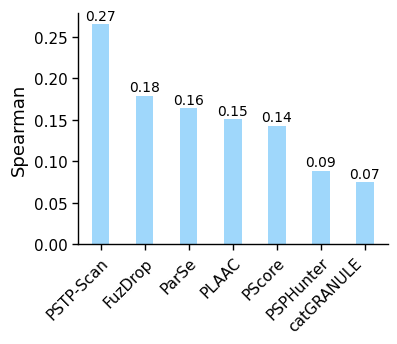

In [7]:
'''   
Overall 
Pearson/Spearman barplot comparison
'''
import numpy as np
import matplotlib.pyplot as plt
labels = ['PSTP-Scan','FuzDrop','ParSe','PLAAC',
          'PScore','PSPHunter','catGRANULE',
          ]

spearmans = [0.265,0.179,0.164,
             0.151,0.143,0.089,
             0.075,]

bar_width = 0.4
index = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(4,3))


bar2 = ax.bar(index, spearmans, bar_width, 
              label='Spearman', color='lightskyblue',alpha=0.8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=11)
ax.set_ylabel('Spearman',fontsize=13)

ax.set_xticklabels(labels,rotation=45,ha='right',rotation_mode='anchor',
                   fontsize=11)
ax.set_xticks(index)
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bar2)
plt.show()

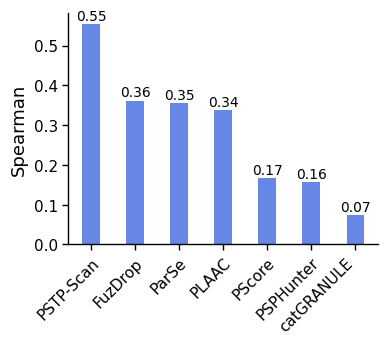

In [8]:
import numpy as np
import matplotlib.pyplot as plt
labels = ['PSTP-Scan','FuzDrop','ParSe','PLAAC',
          'PScore','PSPHunter','catGRANULE',
          ]
# #slidenn best 0.5528440481464337
# PScore 0.3380411272917718
# catGRANULE 0.0735507205984951
# PSPhunter 0.1557345753061225
# FuzDrop 0.36098121126607485
# IUPred 0.4632398863419438
# ParSe 0.35503157218717535
# Plaac 0.16676992087467996
## residue level spearmans
spearmans = [0.553,0.361,0.355,0.338,0.167,0.156,0.074]

bar_width = 0.4
index = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(4,3))
bar2 = ax.bar(index, spearmans, bar_width, 
              label='Spearman', color='royalblue',alpha=0.8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=11)
ax.set_ylabel('Spearman',fontsize=13)
# # ax.set_title('Comparison of Paired Data')
ax.set_xticklabels(labels,rotation=45,ha='right',rotation_mode='anchor',
                   fontsize=11)
ax.set_xticks(index)

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bar2)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


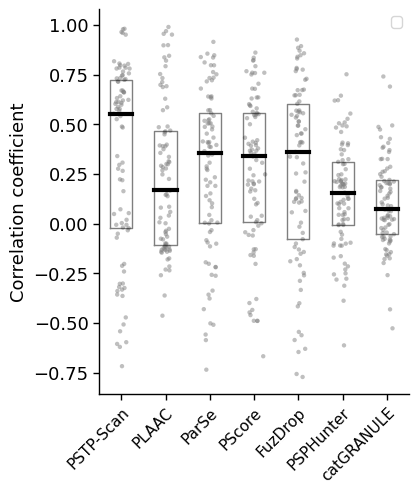

In [9]:
import seaborn as sns
from statannot import add_stat_annotation

_,_ = best_slidenn_seq_pearson,best_slidenn_seq_spear
_,_ = pscore_seq_pearson,pscore_seq_spear
_,_ = fuzdrop_seq_pearson,fuzdrop_seq_spear
_,_ = hunter_seq_pearson,hunter_seq_spear
_,_ = catgra_seq_pearson,catgra_seq_spear
fig, ax = plt.subplots(figsize=(4, 5))
dat = [best_slidenn_seq_pearson,plaac_seq_pearson,parse_seq_pearson,
      pscore_seq_pearson,fuzdrop_seq_pearson,hunter_seq_pearson,
      catgra_seq_pearson]
ax.boxplot(
    dat,
    boxprops=dict(alpha=0.5),
    whiskerprops=dict(visible=False), 
    capprops=dict(visible=False),  
    showfliers=False,
    medianprops=dict(color='black', linewidth=3),)
for i in range(len(dat)):
    y = dat[i]
    x = np.random.normal(1 + i, 0.08, size=len(y))  
    ax.scatter(x, y, alpha=0.5, color='gray', edgecolor='none',s=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=13)
ax.set_ylabel('Correlation coefficient',fontsize=13)
ax.set_xlabel('')
# # ax.set_title('Comparison of Paired Data')
ax.set_xticklabels(
   ['PSTP-Scan','PLAAC','ParSe','PScore','FuzDrop','PSPHunter','catGRANULE',],
    rotation=45,ha='right',rotation_mode='anchor',fontsize=11)

legend = ax.legend()
title = legend.get_title()

title.set_fontsize(12)   
title.set_fontweight('medium')

for handle in legend.legendHandles:
    handle.set_alpha(0.5) 
# plt.tight_layout()

plt.show()

Ttest_indResult(statistic=84.7693875615296, pvalue=0.0)
Ttest_indResult(statistic=56.62124052717427, pvalue=0.0)
Ttest_indResult(statistic=66.72436044356336, pvalue=0.0)
Ttest_indResult(statistic=28.25836549130844, pvalue=7.023736863316927e-175)
Ttest_indResult(statistic=46.00846853017365, pvalue=0.0)
Ttest_indResult(statistic=26.289881739106146, pvalue=9.898443217206147e-152)
Ttest_indResult(statistic=43.21134220769277, pvalue=0.0)


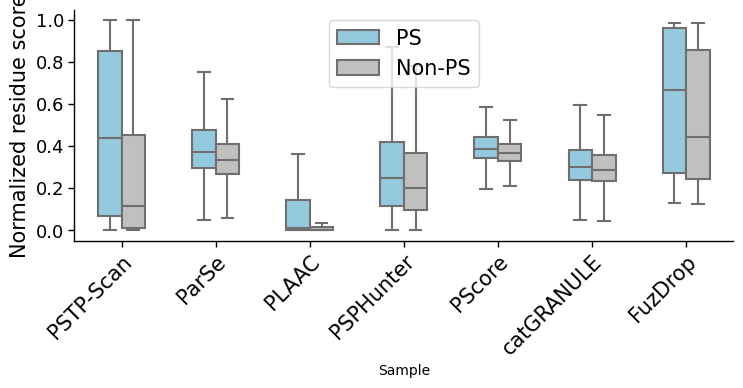

In [10]:
from scipy.stats import ttest_ind

dsize = len(full_slide_nn_best_pos_score)
def minmax(lst):
    lst = np.array(lst)
    lst = (lst-np.min(lst))/(np.max(lst)-np.min(lst))
    return list(lst)
def normal_(lst):
    lst = np.array(lst)
    lst = (lst-np.mean(lst))/(np.std(lst))
    lst = (lst-np.min(lst))/(np.max(lst)-np.min(lst))
    return list(lst)
def classify_positive_negative(score_lst,bool_lst):
    pos_lst,neg_lst = [],[]
    for item,l in zip(score_lst,bool_lst):
        if l == 0:
            neg_lst.append(item)
        else:
            pos_lst.append(item) 
    return pos_lst,neg_lst 
si,sb = classify_positive_negative(
    full_slide_nn_best_pos_score,full_inps_bool_lst)
pai,pab = classify_positive_negative(
    full_parse_all,full_inps_bool_lst)
pli,plb = classify_positive_negative(
    full_plaac_all,full_inps_bool_lst)
hi,hb = classify_positive_negative(
    full_psphunter_all,full_inps_bool_lst)
pi,pb = classify_positive_negative(
    full_pscore_all,full_inps_bool_lst) 
ci,cb = classify_positive_negative(
    full_catgra_all,full_inps_bool_lst) 
fi,fb = classify_positive_negative(
    full_fuzpdp_all,full_inps_bool_lst)
print(ttest_ind(si,sb))
print(ttest_ind(pai,pab))
print(ttest_ind(pli,plb))
print(ttest_ind(hi,hb))
print(ttest_ind(pi,pb))
print(ttest_ind(ci,cb))
print(ttest_ind(fi,fb))


data = {
    'Sample': 
            ['PSTP-Scan'] * dsize +\
            ['ParSe'] * dsize +\
            ['PLAAC'] * dsize +\
            ['PSPHunter'] * dsize +\
            ['PScore'] * dsize +\
            ['catGRANULE'] * dsize+\
            ['FuzDrop']*dsize,
    'Condition': \
        ['PS'] * len(si) + ['Non-PS'] * len(sb) + \
        ['PS'] * len(pai) + ['Non-PS'] * len(pab) + \
        ['PS'] * len(pli) + ['Non-PS'] * len(plb) + \
        ['PS'] * len(hi) + ['Non-PS'] * len(hb) + \
        ['PS'] * len(pi) + ['Non-PS'] * len(pb) + \
        ['PS'] * len(ci) + ['Non-PS'] * len(cb) + \
        ['PS'] * len(fi) + ['Non-PS'] * len(fb),
    'Value': \
    si+sb+\
    minmax(pai+pab)+\
    normal_(pli+plb)+\
    minmax(hi+hb)+\
    minmax(pi+pb)+\
    minmax(ci+cb)+\
    fi+fb,
}

df = pd.DataFrame(data)
plt.figure(figsize=(8.5, 3))

ax = sns.boxplot(
    x='Sample', y='Value', hue='Condition',showfliers=False,
    palette=['skyblue','silver'],linewidth=1.5,width=0.5,
    data=data, )
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=13)
ax.set_ylabel('Normalized residue score',fontsize=15)
# # ax.set_title('Comparison of Paired Data')
ax.set_xticklabels(
    ['PSTP-Scan','ParSe','PLAAC','PSPHunter','PScore','catGRANULE','FuzDrop',],
    rotation=45,ha='right',rotation_mode='anchor',fontsize=15)

legend = ax.legend(fontsize=15)
title = legend.get_title()

title.set_fontsize(15)   
title.set_fontweight('medium')
plt.show()

In [11]:
''' 
venn comparison
'''
# fig, ax = plt.subplots(figsize=(3,3))
# from matplotlib_venn import venn2
# import matplotlib.pyplot as plt   
# venn = venn2(subsets = (23,97,120,),   
#       set_labels = ('','',)) 
# # venn = venn2(subsets = (39,167,105,), # hunter
# #       set_labels = ('','',))
# # venn = venn2(subsets = (34,109,110), # FuzDrop  
# #       set_labels = ('','',)) 
# # venn = venn2(subsets = (18391,18653,28738), 
# #       set_labels = ('','',))
# # venn = venn2(subsets = (45929,1200,1349),  # hunter
# #       set_labels = (None,None,))
# # venn = venn2(subsets = (22115,15512,25014), # fuz
# #       set_labels = ('','',))
# venn.get_patch_by_id('10').set_color('violet')
# venn.get_patch_by_id('01').set_color('thistle')
# venn.get_patch_by_id('11').set_color('mediumorchid')
# for subset in venn.subset_labels:
#     subset.set_visible(False)
# # venn.get_patch_by_id('11').set_color('yellow')
# # plt.savefig('figures/phasepro_analyze/venn_slidenn.svg',
# #             dpi=600,format='svg')
# plt.show()

' \nvenn comparison\n'

In [12]:
########## analyze phasepro domain and sliding nn
